In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn import preprocessing
from scipy import signal
import plotly.graph_objects as go

import os


In [2]:
#print(os.getcwd())
u_df = pd.read_csv('../TrainingLib/unlabelled_input_skin_pfux7.csv')
u_df.head()

,date,project_id,plate_no,Th,Tl,well,primer,filename_input,start,signal_1,...,signal_1092,signal_1093,signal_1094,signal_1095,signal_1096,signal_1097,signal_1098,signal_1099,signal_1100,signal_1101
0,20190913,pfux7,23,56,53,A01,GradientPCR,20190913_GradientPCR_1_56_53Run01_A01,1500,1161,...,299,319,295,291,307,286,312,283,314,323
1,20190913,pfux7,23,56,53,A02,GradientPCR,20190913_GradientPCR_1_56_53Run01_A02,1500,1058,...,407,407,433,428,416,383,375,452,410,387
2,20190913,pfux7,23,56,53,A03,GradientPCR,20190913_GradientPCR_1_56_53Run01_A03,1500,1655,...,244,261,248,237,262,267,239,271,276,281
3,20190913,pfux7,23,56,53,A04,GradientPCR,20190913_GradientPCR_1_56_53Run01_A04,1500,2530,...,252,243,253,265,227,237,243,229,234,229
4,20190913,pfux7,23,56,53,A05,GradientPCR,20190913_GradientPCR_1_56_53Run01_A05,1500,595,...,275,296,271,299,334,287,289,315,317,313


In [4]:
# pfux7_in_df = pd.read_csv('../TrainingLib/pfux7/input_data_pfux7.csv')
# pfux7_out_df = pd.read_csv('../TrainingLib/pfux7/output_data_pfux7.csv')
# gel_in_df = pd.read_csv('../TrainingLib/geltesting/input_data_gel_v3.csv')
# gel_out_df = pd.read_csv('../TrainingLib/geltesting/output_data_gel_v3.csv')
l_df = pd.read_csv('../TrainingLib/labelled_input_skin_pfux7.csv')

In [5]:
# gel_in_df.head()
l_df.head()

,date,project_id,plate_no,Th,Tl,well,primer,filename_input,start,signal_1,...,signal_1092,signal_1093,signal_1094,signal_1095,signal_1096,signal_1097,signal_1098,signal_1099,signal_1100,signal_1101
0,20190809,pfux7,29,53,50,A01,EFSYMB-15,20190809_EFSYMB_15_plate29_53_50_Run01_A01,1500,941,...,296,317,306,330,328,325,331,327,315,280
1,20190809,pfux7,29,53,50,A02,EFSYMB-15,20190809_EFSYMB_15_plate29_53_50_Run01_A02,1500,638,...,301,295,298,310,333,306,321,292,275,298
2,20190809,pfux7,29,53,50,A03,EFSYMB-15,20190809_EFSYMB_15_plate29_53_50_Run01_A03,1500,394,...,245,240,272,260,264,244,246,234,238,219
3,20190809,pfux7,29,53,50,A04,EFSYMB-15,20190809_EFSYMB_15_plate29_53_50_Run01_A04,1500,535,...,312,308,304,307,306,314,337,304,310,311
4,20190809,pfux7,29,53,50,A05,EFSYMB-15,20190809_EFSYMB_15_plate29_53_50_Run01_A05,1500,631,...,242,280,4289,253,272,265,248,240,238,234


In [ ]:
# gel_df = gel_in_df.merge(gel_out_df,left_on='Row',right_on='Wells')

In [ ]:
# pfux7_df = pfux7_in_df.merge(pfux7_out_df,left_on='Row',right_on='Wells')



In [ ]:
# df = pd.concat([gel_df,pfux7_df])
# df.to_csv('../TrainingLib/semi_supervised/labelled_data.csv')
# del(gel_in_df)
# del(gel_out_df)
# del(pfux7_in_df)
# del(pfux7_out_df)

## Peak Extraction
In this section we will take the raw electropherograms and extract individual peaks. For that we need to preprocess 
the data. 

### Preprocessing
We will transform the signal so that it is normalized and noise-free. 


In [14]:
# df= pd.read_csv('../TrainingLib/semi_supervised/labelled_data.csv',index_col=0)
# u_df = pd.read_csv('../unlabelled_skin_assay.csv')

In [15]:
# df = df.drop('Wells',axis=1).set_index('Row')

In [6]:
X_l = l_df.filter(regex='signal_',axis=1).copy()
X_u = u_df.filter(regex='signal_',axis=1).copy()

In [7]:
# Gaussian Filter
X_l_f = X_l\
    .rolling(window=10,win_type='general_gaussian',center=True,axis=1)\
    .mean(power=2,width=0.8)
X_u_f = X_u\
    .rolling(window=10,win_type='general_gaussian',center=True,axis=1)\
    .mean(power=2,width=0.8)
# Remove baseline
X_l_f = X_l_f\
    .add(-X_l_f.rolling(window=50,min_periods=1,axis=1).min())
X_u_f = X_u_f\
    .add(-X_u_f.rolling(window=50,min_periods=1,axis=1).min())
# Min Max Scale
x_l_f = X_l_f.values #returns a numpy array
x_u_f = X_u_f.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled_l = np.transpose(min_max_scaler.fit_transform(x_l_f.T))
x_scaled_u = np.transpose(min_max_scaler.fit_transform(x_u_f.T))
X_l_f = pd.DataFrame(x_scaled_l,columns=X_l.columns)
X_u_f = pd.DataFrame(x_scaled_u,columns=X_u.columns)



In [16]:
#x_f = X_l_f.sample(n=1,random_state=10).values
#x = X_l.sample(n=1,random_state=10).values
x_f = X_l_f.iloc[700,:].values
x = X_l.iloc[700,:].values
#x = X_l.sample(n=1).values

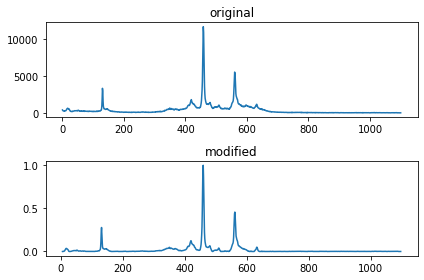

In [17]:
fig,ax = plt.subplots(nrows=2)
ax[0].plot(x.flatten())
ax[0].set_title('original')
ax[1].plot(x_f.flatten())
ax[1].set_title('modified')
plt.tight_layout()

In [18]:
del(X_l)
del(X_u)
del(x_u_f)
del(x_l_f)
del(x_scaled_l)
del(x_scaled_u)
del(min_max_scaler)

### Peak Extraction
We will now extract peaks and their position


In [20]:
X_l_f.set_index(l_df.filename_input,inplace=True)
X_u_f.set_index(u_df.filename_input,inplace=True)

In [37]:
def get_peaks(df,window,start=1500):
    pk_data = []
    for idx,row in df.iterrows():
        peaks = signal.find_peaks(row.values,prominence=0.025)
        #check if blank
        if len(peaks[0]) >= 20:
            continue
        for loc,prom in zip(peaks[0],peaks[1].get('prominences')):
            pk = row.values[loc-window:loc+window]
            t = start + loc
            pk = [idx,t] + pk.flatten().tolist()
            pk_data.append(pk)
    out = pd.DataFrame(pk_data)
    out.rename({0:'file_id',1:'x'},axis=1,inplace=True)
    
    return out
peak_df = get_peaks(X_l_f,20)

In [38]:
peak_u_df = get_peaks(X_u_f,20)
# Y = l_df.filter(regex='values')
Y = pd.read_csv('../TrainingLib/labels_skin_pfux7.csv')
#peak_df.head()

In [39]:
Y = Y.set_index(Y.Wells)
Y = Y.drop('Wells',axis=1)
Y.head()

,values_1,values_2,values_3,values_4,values_5,values_6,values_7,values_8,values_9
Wells,,,,,,,,,
20190809_EFSYMB_15_plate29_53_50_Run01_A01,0,0,0,0,0,0,0,0,0
20190809_EFSYMB_15_plate29_53_50_Run01_A02,0,0,0,0,0,0,0,0,0
20190809_EFSYMB_15_plate29_53_50_Run01_A03,1903,0,0,0,0,0,0,0,0
20190809_EFSYMB_15_plate29_53_50_Run01_A04,2107,0,0,0,0,0,0,0,0
20190809_EFSYMB_15_plate29_53_50_Run01_A05,2106,0,0,0,0,0,0,0,0


In [33]:
def match_labels(df):
    y = Y.loc[df.file_id].values
    if (np.abs((y-df.x))<2.0).any():
        label = 1
    else:
        label = 0
    return label

#labels = peak_df.apply(match_labels,axis=1)

In [34]:
labels = peak_df.apply(match_labels,axis=1)

In [35]:
peak_df.head(20)


,file_id,x,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,20190809_EFSYMB_15_plate29_53_50_Run01_A01,1888,0.009387,0.009173,0.009321,0.008870,0.007801,0.005849,0.006065,0.007332,...,0.135155,0.127195,0.122741,0.118642,0.120605,0.124620,0.124330,0.124364,0.117924,0.103423
1,20190809_EFSYMB_15_plate29_53_50_Run01_A02,1573,0.025483,0.021731,0.019925,0.018594,0.021440,0.034560,0.051528,0.059095,...,0.053008,0.048609,0.042482,0.035279,0.030695,0.028947,0.031247,0.029866,0.026683,0.025332
2,20190809_EFSYMB_15_plate29_53_50_Run01_A02,1692,0.075129,0.076732,0.079723,0.086002,0.093314,0.096493,0.110658,0.117622,...,0.542799,0.644920,0.633768,0.497497,0.381183,0.349270,0.373369,0.374441,0.330595,0.278933
3,20190809_EFSYMB_15_plate29_53_50_Run01_A02,1703,0.104255,0.105055,0.109278,0.113175,0.132279,0.210200,0.409068,0.677522,...,0.367429,0.441431,0.478466,0.476027,0.426181,0.380984,0.397959,0.398293,0.324176,0.222443
4,20190809_EFSYMB_15_plate29_53_50_Run01_A02,1715,0.249350,0.237175,0.268347,0.347085,0.439528,0.470663,0.474365,0.542799,...,0.033415,0.007101,0.000000,0.000000,0.000000,0.003304,0.016724,0.029991,0.033538,0.024223
5,20190809_EFSYMB_15_plate29_53_50_Run01_A02,1905,0.007820,0.007402,0.006324,0.005863,0.007200,0.009356,0.009005,0.010801,...,0.055211,0.050671,0.046698,0.040129,0.041407,0.046483,0.044700,0.044955,0.044333,0.039748
6,20190809_EFSYMB_15_plate29_53_50_Run01_A03,1626,0.003590,0.003028,0.004689,0.007253,0.007407,0.006174,0.010169,0.013540,...,0.048955,0.042930,0.040309,0.035811,0.030678,0.029570,0.026546,0.022016,0.021971,0.022915
7,20190809_EFSYMB_15_plate29_53_50_Run01_A03,1711,0.015725,0.018524,0.020562,0.019813,0.019667,0.022377,0.022199,0.024346,...,0.378077,0.390065,0.350628,0.314890,0.317435,0.346085,0.376189,0.373825,0.330523,0.314384
8,20190809_EFSYMB_15_plate29_53_50_Run01_A03,1734,0.208193,0.228139,0.222122,0.205373,0.197518,0.237170,0.315111,0.378077,...,0.427226,0.538485,0.605863,0.600236,0.592606,0.655275,0.805687,0.926260,0.882981,0.703937
9,20190809_EFSYMB_15_plate29_53_50_Run01_A03,1751,0.397687,0.607993,0.855889,1.000000,0.963037,0.756390,0.515569,0.366449,...,0.155460,0.162820,0.236977,0.323724,0.350088,0.283575,0.163476,0.008824,0.000000,0.000000


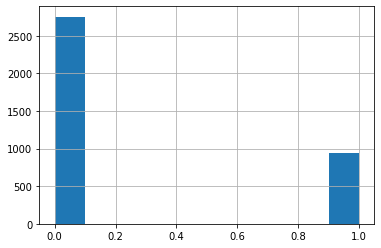

In [36]:
labels.hist()



In [66]:
idx = 735
indices = signal.find_peaks(X_l_f.iloc[idx,:].values,prominence=0.1)[0]
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=X_l_f.iloc[idx,:].values,
    mode='lines+markers',
    name='Original Plot'
))

fig.add_trace(go.Scatter(
    x=indices,
    y=[X_l_f.iloc[idx,:].values[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='cross'
    ),
    name='Detected Peaks'
))

fig.show()


In [135]:
labels = labels.to_frame()
labels.columns=['label']

In [136]:
peak_df.to_csv('peak_signals.csv')
labels.to_csv('peak_labels.csv')
peak_u_df.to_csv('peak_signals_unlabelled.csv')

## Training Peak Data
We will now try to predict whether a peak is a real peak from the data.
We have some unlabelled input, which we will try to use to our advantage using semi-supervised learning.



In [116]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score



In [137]:
peak_df = pd.read_csv('peak_signals.csv',index_col=0)
labels = pd.read_csv('peak_labels.csv',index_col=0)
peak_u_df = pd.read_csv('peak_signals_unlabelled.csv',index_col=0)

In [141]:
peak_df.drop('file_id',axis=1,inplace=True)
peak_df.head()

,x,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,1657,0.072214,0.084023,0.080332,0.085349,0.109464,0.142351,0.188487,0.258657,0.354917,...,0.506459,0.475301,0.389373,0.309256,0.251592,0.186901,0.144204,0.124257,0.103209,0.085576
1,1850,0.177055,0.294539,0.441576,0.564403,0.613771,0.594455,0.576869,0.628023,0.768377,...,1.000000,0.934976,0.803789,0.676313,0.607148,0.559899,0.510077,0.473239,0.427409,0.386399
2,1928,0.017496,0.038551,0.067809,0.087296,0.101900,0.128406,0.183925,0.269334,0.389496,...,0.547178,0.526926,0.459349,0.385905,0.329654,0.296976,0.265732,0.258762,0.248773,0.235170
3,1943,0.296976,0.265732,0.258762,0.248773,0.235170,0.239287,0.278478,0.347079,0.452334,...,0.645148,0.641077,0.569082,0.467756,0.397629,0.339014,0.283918,0.234427,0.205282,0.190497
4,1642,0.062819,0.085935,0.097649,0.096528,0.105490,0.136676,0.185408,0.233831,0.322183,...,0.562444,0.545554,0.459734,0.373628,0.294097,0.220443,0.160111,0.117794,0.098581,0.090342


In [139]:
labels.head()

,label
0,0
1,1
2,1
3,1
4,0


In [ ]:
model = KNeighborsClassifier()
model.fit(x)

In [142]:
classifier_factory = [KNeighborsClassifier(),RandomForestClassifier()]
num_folds = 3
for model in classifier_factory:
    
    scores = cross_val_score(model,peak_df,labels,cv=num_folds,scoring='f1')
    score_description = "%0.2f (+- %0.2f)" % (scores.mean(),scores.std())
    print('{model:25} CV-5 F1 SCORE: {score}'.format(
        model= model.__class__.__name__,
        score=score_description
    ) )

KNeighborsClassifier      CV-5 F1 SCORE: nan (+- nan)
RandomForestClassifier    CV-5 F1 SCORE: nan (+- nan)


/anaconda3/envs/ScoringElectropherograms/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').


/anaconda3/envs/ScoringElectropherograms/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').


/anaconda3/envs/ScoringElectropherograms/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').


/anaconda3